In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch

from double_jig_gen.data import ABCDataset, get_oneills_dataloaders, get_folkrnn_dataloaders
from double_jig_gen.tokenizers import Tokenizer

logging.basicConfig()
LOGGER = logging.getLogger(__name__)
LOGGER.setLevel("DEBUG")

In [3]:
DEVICE_ID = 7
DATA_HOME = "/disk/scratch_fast/s0816700/data"
DATA_PATH = f"{DATA_HOME}/folk-rnn/data_v3"
DATA_URL = "https://raw.githubusercontent.com/IraKorshunova/folk-rnn/master/data/data_v3"

In [4]:
# https://github.com/IraKorshunova/folk-rnn/blob/master/configurations/config5.py
ONE_HOT = True
EMBEDDING_SIZE = 256  # is ignored if one_hot=True
NUM_LAYERS = 3
RNN_SIZE = 512
DROPOUT = 0.5

LEARNING_RATE = 0.003
LEARNING_RATE_DECAY_AFTER = 20
LEARNING_RATE_DECAY = 0.97

BATCH_SIZE = 64
MAX_EPOCH = 100
GRAD_CLIPPING = 5
VALIDATION_FRACTION = 0.05
VALIDATE_EVERY = 1000  # iterations

SAVE_EVERY = 10  # epochs

In [5]:
LOGGER.info(f"Changing to device {DEVICE_ID}")
os.environ["CUDA_VISIBLE_DEVICES"] = f"{DEVICE_ID}"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

INFO:__main__:Changing to device 7


In [6]:
Path(DATA_PATH).parent.mkdir(parents=True, exist_ok=True)

In [7]:
if not Path(DATA_PATH).exists():
    LOGGER.info(f"Dowloading data from {DATA_URL}")
    ! wget {DATA_URL} -O {DATA_PATH}
else:
    LOGGER.info(f"Data exists at {DATA_PATH}")

INFO:__main__:Data exists at /disk/scratch_fast/s0816700/data/folk-rnn/data_v3


In [8]:
with open(DATA_PATH, 'r') as fh:
    data = fh.read()

In [9]:
data[:1000]

'M:9/8\nK:maj\n=G =E =E =E 2 =D =E =D =C | =G =E =E =E =F =G =A =B =c | =G =E =E =E 2 =D =E =D =C | =A =D =D =G =E =C =D 2 =A | =G =E =E =E 2 =D =E =D =C | =G =E =E =E =F =G =A =B =c | =G =E =E =E 2 =D =E =D =C | =A =D =D =G =E =C =D 2 =D | =E =D =E =c 2 =A =B =A =G | =E =D =E =A /2 =B /2 =c =A =B 2 =D | =E =D =E =c 2 =A =B =A =G | =A =D =D =D =E =G =A 2 =D | =E =D =E =c 2 =A =B =A =G | =E =D =E =A /2 =B /2 =c =A =B 2 =B | =G =A =B =c =B =A =B =A =G | =A =D =D =D =E =G =A =B =c |\n\nM:4/4\nK:dor\n|: =d =D =D /2 =D /2 =D =A =D =D /2 =D /2 =D | =d =D =D /2 =D /2 =D =c 2 =B =c | =d =D =D /2 =D /2 =D =A =G ^F =A | =G =E =C =E =G =A =B =c | =d =D =D /2 =D /2 =D =A =D =D /2 =D /2 =D | =d =D =D /2 =D /2 =D =c 2 =B =c | =d =B =B =A =B =d =c =A |1 =G =E =C =E =G =A =B =c :| |2 =G =E =C =E =G 2 =F =G |: =A 2 =F =A =D =A =F =A - | =A =G =A =B =c 2 =B =c | =A 2 =F =A =D =A =F =A | =G 2 =E =G =C =G =E =G | =A 2 [ =F =A ] 2 [ =D =A - ] 2 [ =F =A ] =A - | =A =G =A =B =c 2 =B =c | =d =B =B =A =B =d =c

data are tokens separated by spaces, and pieces separated by to `\n` characters. Pieces begin with a meter, then a new line with a key, then a new line with the piece.

In [10]:
tokens_set = set(data.split())
vocab_size = len(tokens_set)
print(f"vocabulary size: {vocab_size}")
print(f"vocabulary (each token separated by a space): \n{' '.join(sorted(tokens_set))}")

vocabulary size: 102
vocabulary (each token separated by a space): 
(2 (3 (4 (5 (6 (7 - /2 /2< /2> /3 /4 /4< /8 12 16 2 2< 2> 3 3/2 3/4 3> 4 4> 5 5/2 6 7 7/2 8 9 9/2 :| < =A =A, =B =B, =C =C, =D =D, =E =E, =F =F, =G =G, =a =a' =b =b' =c =c' =d =d' =e =e' =f =f' =g =g' > K:dor K:maj K:min K:mix M:12/8 M:2/4 M:3/2 M:3/4 M:4/4 M:6/8 M:9/8 [ ] ^A ^A, ^C ^C, ^D ^D, ^F ^F, ^G ^G, ^a ^a' ^c ^c' ^d ^d' ^f ^f' ^g ^g' z | |1 |2 |:


In [11]:
tokenizer = Tokenizer(tokens=set(data.split()))

In [12]:
tunes = [tune.split() for tune in data.split('\n\n')]
tokenized_tunes = [tokenizer.tokenize(tune) for tune in tunes]

In [13]:
# dataset = ABCDataset(filepath=DATA_PATH)
dataset = ABCDataset(tunes=tunes)

In [14]:
print(dataset)

vocabulary size: 106
vocabulary (each token separated by a space): 
<pad> <unk> <s> </s> (2 (3 (4 (5 (6 (7 - /2 /2< /2> /3 /4 /4< /8 12 16 2 2< 2> 3 3/2 3/4 3> 4 4> 5 5/2 6 7 7/2 8 9 9/2 :| < =A =A, =B =B, =C =C, =D =D, =E =E, =F =F, =G =G, =a =a' =b =b' =c =c' =d =d' =e =e' =f =f' =g =g' > K:dor K:maj K:min K:mix M:12/8 M:2/4 M:3/2 M:3/4 M:4/4 M:6/8 M:9/8 [ ] ^A ^A, ^C ^C, ^D ^D, ^F ^F, ^G ^G, ^a ^a' ^c ^c' ^d ^d' ^f ^f' ^g ^g' z | |1 |2 |:
dataset_size: 45850
tune length stats:
	* max 2112
	* mean 173.4827044711014
	* median 153.0
	* min 37


# Exclude long tunes
We will need to batch all the data. Exclude very long examples for efficiency.

In [15]:
tune_lens = np.array([len(t) for t in tunes])

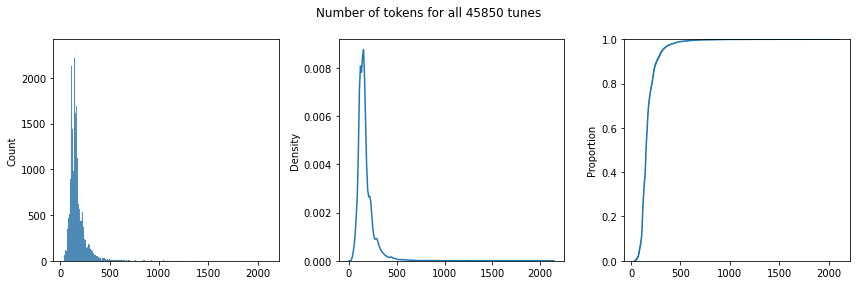

In [16]:
plt.figure(figsize=(12,4))
plt.subplot(131)
sns.histplot(tune_lens)
plt.subplot(132)
sns.kdeplot(tune_lens)
plt.subplot(133)
sns.ecdfplot(tune_lens)
plt.suptitle(f"Number of tokens for all {len(tunes)} tunes")
plt.tight_layout()

In [17]:
pct = .99
nr_kept = int(np.rint(len(tune_lens)*pct))
val_pct = sorted(tune_lens)[nr_kept - 1]
val_pct

517

In [18]:
short_tunes = [tune for tune in tunes if len(tune) <= val_pct]

In [19]:
short_tune_lens = np.array([len(t) for t in short_tunes])

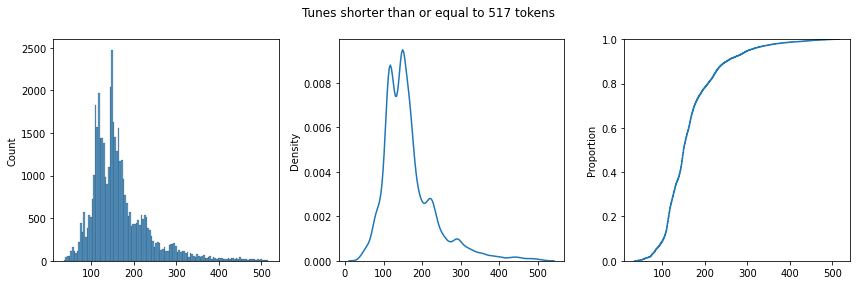

In [20]:
plt.figure(figsize=(12,4))
plt.subplot(131)
sns.histplot(short_tune_lens)
plt.subplot(132)
sns.kdeplot(short_tune_lens)
plt.subplot(133)
sns.ecdfplot(short_tune_lens)
plt.suptitle(f"Tunes shorter than or equal to {val_pct} tokens")
plt.tight_layout()

# Train valid split

In [21]:
ntunes = len(short_tunes)

In [22]:
nvalid_tunes = ntunes * VALIDATION_FRACTION
# round to a multiple of batch_size
nvalid_tunes = BATCH_SIZE * max(
    1,
    int(np.rint(nvalid_tunes / BATCH_SIZE))
)
nvalid_tunes

2240

In [23]:
rng = np.random.RandomState(42)
valid_idxs = rng.choice(np.arange(ntunes), nvalid_tunes, replace=False)

In [24]:
ntrain_tunes = ntunes - nvalid_tunes
train_idxs = np.delete(np.arange(ntunes), valid_idxs)

In [25]:
valid_tunes = [tune for idx, tune in enumerate(short_tunes) if idx in valid_idxs]
train_tunes = [tune for idx, tune in enumerate(short_tunes) if idx in train_idxs]

In [26]:
valid_dataset = ABCDataset(tunes=valid_tunes, tokens=dataset.tokens)
train_dataset = ABCDataset(tunes=train_tunes, tokens=dataset.tokens)

In [27]:
print(train_dataset)

vocabulary size: 106
vocabulary (each token separated by a space): 
<pad> <unk> <s> </s> (2 (3 (4 (5 (6 (7 - /2 /2< /2> /3 /4 /4< /8 12 16 2 2< 2> 3 3/2 3/4 3> 4 4> 5 5/2 6 7 7/2 8 9 9/2 :| < =A =A, =B =B, =C =C, =D =D, =E =E, =F =F, =G =G, =a =a' =b =b' =c =c' =d =d' =e =e' =f =f' =g =g' > K:dor K:maj K:min K:mix M:12/8 M:2/4 M:3/2 M:3/4 M:4/4 M:6/8 M:9/8 [ ] ^A ^A, ^C ^C, ^D ^D, ^F ^F, ^G ^G, ^a ^a' ^c ^c' ^d ^d' ^f ^f' ^g ^g' z | |1 |2 |:
dataset_size: 43156
tune length stats:
	* max 519
	* mean 167.7377653165261
	* median 152.0
	* min 37


In [28]:
print(valid_dataset)

vocabulary size: 106
vocabulary (each token separated by a space): 
<pad> <unk> <s> </s> (2 (3 (4 (5 (6 (7 - /2 /2< /2> /3 /4 /4< /8 12 16 2 2< 2> 3 3/2 3/4 3> 4 4> 5 5/2 6 7 7/2 8 9 9/2 :| < =A =A, =B =B, =C =C, =D =D, =E =E, =F =F, =G =G, =a =a' =b =b' =c =c' =d =d' =e =e' =f =f' =g =g' > K:dor K:maj K:min K:mix M:12/8 M:2/4 M:3/2 M:3/4 M:4/4 M:6/8 M:9/8 [ ] ^A ^A, ^C ^C, ^D ^D, ^F ^F, ^G ^G, ^a ^a' ^c ^c' ^d ^d' ^f ^f' ^g ^g' z | |1 |2 |:
dataset_size: 2240
tune length stats:
	* max 519
	* mean 170.44241071428573
	* median 154.0
	* min 38


In [29]:
train_dataset[0][:10]

tensor([ 2, 78, 69, 51, 47, 47, 47, 20, 45, 47])

In [30]:
train_dataset.tokenizer.untokenize(train_dataset[0])[:10]

['<s>', 'M:9/8', 'K:maj', '=G', '=E', '=E', '=E', '2', '=D', '=E']

In [31]:
valid_dataset[0][:10]

tensor([  2,  77,  69,  39,  89,  39,  59,  57,  39, 102])

In [32]:
train_dataset.tokenizer.untokenize(valid_dataset[0])[:10]

['<s>', 'M:6/8', 'K:maj', '=A', '^G', '=A', '=d', '=c', '=A', '|']

# Batching in the dataloader

In [33]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

PAD_IDX = dataset.tokenizer.pad_token_index

def rpad_batch(batch):
    # Subtract 1 from the sequence length - never want to predict on </s> token
    lengths = [seq.shape[0] for seq in batch]
    data = pad_sequence(batch, batch_first=False, padding_value=PAD_IDX)
    return data, lengths

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=rpad_batch,
    pin_memory=True,
    num_workers=8,
)

In [34]:
for batch in train_dataloader:
    print(batch)
    print(batch[0].size())
    print(max(batch[1]))
    break

[tensor([[ 2,  2,  2,  ...,  2,  2,  2],
        [76, 75, 76,  ..., 77, 76, 75],
        [69, 70, 70,  ..., 70, 71, 71],
        ...,
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0]]), [150, 147, 204, 342, 91, 115, 144, 250, 174, 100, 144, 133, 169, 133, 158, 135, 134, 255, 93, 185, 204, 154, 301, 190, 82, 136, 104, 172, 200, 284, 150, 148, 146, 168, 116, 98, 131, 110, 289, 148, 78, 167, 236, 201, 107, 147, 211, 144, 124, 152, 155, 177, 193, 86, 272, 140, 158, 99, 79, 115, 135, 173, 167, 109]]
torch.Size([342, 64])
342


In [35]:
val_dataloader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=rpad_batch,
    pin_memory=True,
    num_workers=8,
)

# Model

In [36]:
import pytorch_lightning as pl

from double_jig_gen.models import SimpleRNN


In [37]:
lightning_trainer = pl.Trainer(gpus='1,')

GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [7]
INFO:lightning:CUDA_VISIBLE_DEVICES: [7]


In [38]:
model = SimpleRNN(
    rnn_type="LSTM",
    ntoken=dataset.vocabulary_size,
    ninp=EMBEDDING_SIZE,
    nhid=RNN_SIZE,
    nlayers=NUM_LAYERS,
    model_batch_size=BATCH_SIZE,
    dropout=DROPOUT,
    embedding_padding_idx=0,
)

In [ ]:
lightning_trainer.fit(
    model,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

/afs/inf.ed.ac.uk/user/s08/s0816700/miniconda3/envs/dj-gen/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name          | Type      | Params
--------------------------------------------
0 | dropout_layer | Dropout   | 0     
1 | encoder_layer | Embedding | 27 K  
2 | rnn_layer     | LSTM      | 5 M   
3 | decoder_layer | Linear    | 54 K  
INFO:lightning:
  | Name          | Type      | Params
--------------------------------------------
0 | dropout_layer | Dropout   | 0     
1 | encoder_layer | Embedding | 27 K  
2 | rnn_layer     | LSTM      | 5 M   
3 | decoder_layer | Linear    | 54 K  


Epoch 0:  95%|█████████▌| 675/710 [02:23<00:07,  4.71it/s, loss=1.736, v_num=2]
Validating: 0it [00:00, ?it/s]
Epoch 1:  95%|█████████▌| 675/710 [02:22<00:07,  4.73it/s, loss=1.545, v_num=2, validation_loss_mean=1.63]
Validating: 0it [00:00, ?it/s]
Epoch 2:  95%|█████████▌| 675/710 [02:22<00:07,  4.73it/s, loss=1.449, v_num=2, validation_loss_mean=1.43]
Validating: 0it [00:00, ?it/s]
Epoch 3:  95%|█████████▌| 675/710 [02:21<00:07,  4.76it/s, loss=1.545, v_num=2, validation_loss_mean=1.34]
Validating: 0it [00:00, ?it/s]
Epoch 4:  95%|█████████▌| 675/710 [02:22<00:07,  4.75it/s, loss=1.356, v_num=2, validation_loss_mean=1.38]
Validating: 0it [00:00, ?it/s]
Epoch 5:  95%|█████████▌| 675/710 [02:23<00:07,  4.72it/s, loss=1.349, v_num=2, validation_loss_mean=1.25]
Validating: 0it [00:00, ?it/s]
Epoch 6:  95%|█████████▌| 675/710 [02:19<00:07,  4.84it/s, loss=1.347, v_num=2, validation_loss_mean=1.23]
Validating: 0it [00:00, ?it/s]
Epoch 7:  95%|█████████▌| 675/710 [02:22<00:07,  4.75it/s, lo

# Train on oneills

In [45]:
on_dataset = ABCDataset(
    filepath='data/oneills_reformat.abc',
    tokens=dataset.tokens
)

In [46]:
print(on_dataset)

vocabulary size: 106
vocabulary (each token separated by a space): 
<pad> <unk> <s> </s> (2 (3 (4 (5 (6 (7 - /2 /2< /2> /3 /4 /4< /8 12 16 2 2< 2> 3 3/2 3/4 3> 4 4> 5 5/2 6 7 7/2 8 9 9/2 :| < =A =A, =B =B, =C =C, =D =D, =E =E, =F =F, =G =G, =a =a' =b =b' =c =c' =d =d' =e =e' =f =f' =g =g' > K:dor K:maj K:min K:mix M:12/8 M:2/4 M:3/2 M:3/4 M:4/4 M:6/8 M:9/8 [ ] ^A ^A, ^C ^C, ^D ^D, ^F ^F, ^G ^G, ^a ^a' ^c ^c' ^d ^d' ^f ^f' ^g ^g' z | |1 |2 |:
dataset_size: 361
tune length stats:
	* max 692
	* mean 150.42659279778394
	* median 127.0
	* min 111


In [47]:
nr_unk_toks = 0
for idx in range(len(on_dataset)):
    nr_unk_toks += (
        np.array(on_dataset[idx]) == on_dataset.tokenizer.unk_token_index
    ).sum()
nr_unk_toks

0

In [48]:
on_dataloader = DataLoader(
    on_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=rpad_batch,
    pin_memory=True,
    num_workers=8,
)

In [49]:
early_stop_callback = pl.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.00,
    patience=100,
    verbose=True,
    mode="min",
)

In [50]:
lightning_trainer = pl.Trainer(gpus='0,', deterministic=True, early_stop_callback=early_stop_callback)

GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [7]
INFO:lightning:CUDA_VISIBLE_DEVICES: [7]


In [51]:
lightning_trainer.fit(
    model,
    train_dataloader=on_dataloader,
    val_dataloaders=on_dataloader,
)


  | Name          | Type      | Params
--------------------------------------------
0 | dropout_layer | Dropout   | 0     
1 | encoder_layer | Embedding | 27 K  
2 | rnn_layer     | LSTM      | 5 M   
3 | decoder_layer | Linear    | 54 K  
INFO:lightning:
  | Name          | Type      | Params
--------------------------------------------
0 | dropout_layer | Dropout   | 0     
1 | encoder_layer | Embedding | 27 K  
2 | rnn_layer     | LSTM      | 5 M   
3 | decoder_layer | Linear    | 54 K  


Validation sanity check: 0it [00:00, ?it/s]

/afs/inf.ed.ac.uk/user/s08/s0816700/miniconda3/envs/dj-gen/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


Epoch 0:  50%|█████     | 6/12 [00:01<00:01,  3.35it/s, loss=3.790, v_num=29]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|█████     | 6/12 [00:01<00:01,  3.45it/s, loss=3.415, v_num=29, validation_loss_mean=3.02] 
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 12/12 [00:02<00:00,  4.60it/s, loss=3.415, v_num=29, validation_loss_mean=3.02]

/afs/inf.ed.ac.uk/user/s08/s0816700/miniconda3/envs/dj-gen/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..
INFO:lightning:Saving latest checkpoint..


Epoch 1: 100%|██████████| 12/12 [00:12<00:00,  1.01s/it, loss=3.415, v_num=29, validation_loss_mean=3.02]


1

In [52]:
trn, vld, tst = get_oneills_dataloaders(
    "/disk/scratch_fast/s0816700/data/oneills/oneills_reformat.abc",
    "/disk/scratch_fast/s0816700/data/folk-rnn/data_v3_vocabulary.txt",
    batch_size=16,
    num_workers=1,
    pin_memory=True,
)

In [53]:
for ii in range(len(tst.dataset)):
    print(tst.dataset[ii])

tensor([  2,  77,  69,  89,  20,  57,  57,  89,  57, 102,  59,  81,  59,  57,
         89,  49, 102,  89,  20,  57,  57,  89,  49, 102,  51,  89,  51,  51,
         20,  49, 102,  89,  20,  57,  57,  89,  57, 102,  59,  81,  59,  57,
         89,  49, 102,  89,  57,  89,  81,  51,  85, 102,  49,  51,  49,  49,
         23,  37, 105,  63,  20,  59,  95,  59,  57, 102,  59,  11,  95,  11,
         63,  59,  57,  89,  49, 102,  63,  20,  59,  95,  57,  89, 102,  51,
         89,  51,  51,  89,  57, 102,  63,  20,  59,  95,  59,  57, 102,  59,
         11,  95,  11,  63,  59,  57,  89,  49, 102,  89,  57,  89,  81,  51,
         85, 102,  49,  51,  49,  49,  23,  37,   3])
tensor([  2,  77,  69,  95, 102,  81,  89,  51,  49,  51,  89, 102,  51,  49,
         51,  85,  20,  95, 102,  81,  89,  51,  49,  51,  81, 102,  57,  20,
         81,  57,  59,  95, 102,  81,  89,  51,  49,  51,  89, 102,  51,  49,
         51,  85,  20,  99, 102,  65,  95,  11,  59,  11,  95,  63,  59,  81,
        10

In [54]:
model

SimpleRNN(
  (dropout_layer): Dropout(p=0.5, inplace=False)
  (encoder_layer): Embedding(106, 256, padding_idx=0)
  (rnn_layer): LSTM(256, 512, num_layers=3, dropout=0.5)
  (decoder_layer): Linear(in_features=512, out_features=106, bias=True)
)


Validating: 100%|██████████| 6/6 [00:15<00:00,  3.06it/s]

In [55]:
print(model)
lightning_trainer.test(
    model,
    test_dataloaders=tst,
#             ckpt_path=str(args.model_load_from_checkpoint),
    ckpt_path=None,
)

SimpleRNN(
  (dropout_layer): Dropout(p=0.5, inplace=False)
  (encoder_layer): Embedding(106, 256, padding_idx=0)
  (rnn_layer): LSTM(256, 512, num_layers=3, dropout=0.5)
  (decoder_layer): Linear(in_features=512, out_features=106, bias=True)
)
Testing:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(2.8861, device='cuda:0'),
 'test_loss_mean': tensor(2.8861, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 2/2 [00:00<00:00,  6.35it/s]


[{'test_loss_mean': 2.8860669136047363, 'test_loss': 2.8860669136047363}]